# NutriGood - OCR RCNN for Sugar Detection

Our journey began with discussion and observations in our communities. Many people expressed frustration with the complexity of nutritional labels, particularly when it came to hidden sugars in processed foods/ drinks. NutriGood's mission is to make nutritional transparency a daily habit, ultimately helping users reduce sugar intake and achieve their wellness goals.

## Connect to Dataset On Gdrive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import Libraries

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import Model, Input
import matplotlib.pyplot as plt

## About Dataset

In [3]:
file_path = 'nutrition_data_fix.csv'
nutrition_data = pd.read_csv(file_path)

# Display basic information and the first few rows of the dataset
nutrition_data.info(), nutrition_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Serving Per Package  10000 non-null  int64  
 1   Gula (g)             10000 non-null  float64
 2   Total Gula (g)       10000 non-null  float64
 3   Umur                 10000 non-null  int64  
 4   Berat Badan (kg)     10000 non-null  float64
 5   Riwayat Diabetes     10000 non-null  object 
 6   Kategori Gula        10000 non-null  object 
 7   Rekomendasi          10000 non-null  object 
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


(None,
    Serving Per Package  Gula (g)  Total Gula (g)  Umur  Berat Badan (kg)  \
 0                    7      6.25           43.75    76            117.56   
 1                    4      7.41           29.64    68            113.49   
 2                   13     11.51          149.63    51             70.46   
 3                   11      5.42           59.62    73             81.23   
 4                    8     18.35          146.80    50             77.29   
 
   Riwayat Diabetes Kategori Gula                  Rekomendasi  
 0     Ada Diabetes   Normal Gula             Kurangi Konsumsi  
 1   Tidak Diabetes   Normal Gula             Kurangi Konsumsi  
 2   Tidak Diabetes   Tinggi Gula  Lebih Baik Tidak Dikonsumsi  
 3   Tidak Diabetes   Tinggi Gula  Lebih Baik Tidak Dikonsumsi  
 4     Ada Diabetes   Tinggi Gula  Lebih Baik Tidak Dikonsumsi  )

The code is used to rename a column in a dataframe called nutrition_data for easier handling

In [4]:
# Rename columns
nutrition_data.rename(columns={
    'Serving Per Package': 'serving_per_package',
    'Gula (g)': 'gula',
    'Total Gula (g)': 'total_gula',
    'Umur': 'umur',
    'Berat Badan (kg)': 'berat badan',
    'Kategori Gula': 'kategori_gula',
    'Rekomendasi': 'rekomendasi'
}, inplace=True)

This code is used to convert categorical and recommendation columns into numeric format using LabelEncoder from sklearn library

In [8]:
# Encode categorical columns
label_encoder_kategori = LabelEncoder()
label_encoder_rekomendasi = LabelEncoder()

nutrition_data['kategori_gula'] = label_encoder_kategori.fit_transform(nutrition_data['kategori_gula'])
nutrition_data['rekomendasi'] = label_encoder_rekomendasi.fit_transform(nutrition_data['rekomendasi'])

to separate features and targets from dataframe

In [9]:
# Features and targets
X = nutrition_data[['serving_per_package', 'gula', 'total_gula']].values
y_kategori = nutrition_data['kategori_gula'].values
y_rekomendasi = nutrition_data['rekomendasi'].values

to normalize features using MinMaxScaler

In [10]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

The code is used to split the data into training and testing sets using the train_test_split function.

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train_kategori, y_test_kategori, y_train_rekomendasi, y_test_rekomendasi = train_test_split(
    X_scaled, y_kategori, y_rekomendasi, test_size=0.2, random_state=42
)

then defined the model using CNN. The model is designed to handle two output tasks (multi-output model), namely sugar_category prediction and recommendation.

In [12]:
# Define models 
def modelCnn():
    input_layer = Input(shape=(3,))

    # Shared layers
    shared = Dense(64, activation='relu')(input_layer)
    shared = Dense(32, activation='relu')(shared)

    # Output for kategori_gula
    output_kategori = Dense(len(label_encoder_kategori.classes_), activation='softmax', name='kategori_gula')(shared)

    # Output for rekomendasi
    output_rekomendasi = Dense(len(label_encoder_rekomendasi.classes_), activation='softmax', name='rekomendasi')(shared)

    # Build model
    model = Model(inputs=input_layer, outputs=[output_kategori, output_rekomendasi])

    return model

In [13]:
# summarize models
modelCnn().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kategori_gula       │ (None, 3)         │         99 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rekomendasi (Dense) │ (None, 3)         │         99 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,534 (9.90 KB)

 Trainable params: 2,534 (9.90 KB)

 Non-trainable params: 0 (0.00 B)

compile model use optimizer adam and loss sparse_categorical_crossentropy

In [14]:
# Compile model with multiple loss functions
model = modelCnn()

model.compile(
    optimizer='adam',
    loss={
        'kategori_gula': 'sparse_categorical_crossentropy',
        'rekomendasi': 'sparse_categorical_crossentropy'
    },
    metrics={
        'kategori_gula': 'accuracy',
        'rekomendasi': 'accuracy'
    }
)

In [15]:
# Train the model
history = model.fit(
    X_train, {'kategori_gula': y_train_kategori, 'rekomendasi': y_train_rekomendasi},
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kategori_gula_accuracy: 0.4779 - kategori_gula_loss: 0.9473 - loss: 1.8380 - rekomendasi_accuracy: 0.5277 - rekomendasi_loss: 0.8907 - val_kategori_gula_accuracy: 0.9013 - val_kategori_gula_loss: 0.4457 - val_loss: 0.8427 - val_rekomendasi_accuracy: 0.8794 - val_rekomendasi_loss: 0.3970
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - kategori_gula_accuracy: 0.9122 - kategori_gula_loss: 0.3517 - loss: 0.6660 - rekomendasi_accuracy: 0.9087 - rekomendasi_loss: 0.3142 - val_kategori_gula_accuracy: 0.9331 - val_kategori_gula_loss: 0.2133 - val_loss: 0.4152 - val_rekomendasi_accuracy: 0.9275 - val_rekomendasi_loss: 0.2018
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - kategori_gula_accuracy: 0.9478 - kategori_gula_loss: 0.1783 - loss: 0.3448 - rekomendasi_accuracy: 0.9485 - rekomendasi_loss: 0.1665 - val_kategori_gula_accuracy: 0.9525 - val_kategori_gula_loss: 0.1616 - val_loss: 0.3143 - val_rekomendasi_accuracy: 0.9556 - val

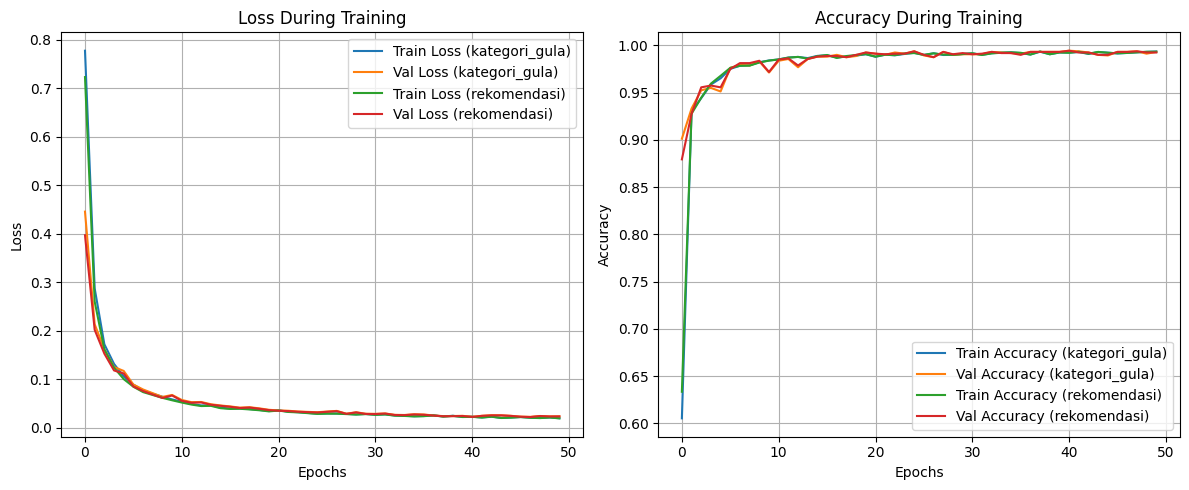

In [ ]:
# Plot Loss
plt.figure(figsize=(12, 5))

# Loss for kategori_gula
plt.subplot(1, 2, 1)
plt.plot(history.history['kategori_gula_loss'], label='Train Loss (kategori_gula)')
plt.plot(history.history['val_kategori_gula_loss'], label='Val Loss (kategori_gula)')
# Loss for rekomendasi
plt.plot(history.history['rekomendasi_loss'], label='Train Loss (rekomendasi)')
plt.plot(history.history['val_rekomendasi_loss'], label='Val Loss (rekomendasi)')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plot Accuracy
# Accuracy for kategori_gula
plt.subplot(1, 2, 2)
plt.plot(history.history['kategori_gula_accuracy'], label='Train Accuracy (kategori_gula)')
plt.plot(history.history['val_kategori_gula_accuracy'], label='Val Accuracy (kategori_gula)')
# Accuracy for rekomendasi
plt.plot(history.history['rekomendasi_accuracy'], label='Train Accuracy (rekomendasi)')
plt.plot(history.history['val_rekomendasi_accuracy'], label='Val Accuracy (rekomendasi)')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

this code to evaluate the performance of multi-output models on test data

In [19]:
# Evaluate the model
loss, loss_kategori, loss_rekomendasi, acc_kategori, acc_rekomendasi = model.evaluate(
    X_test, {'kategori_gula': y_test_kategori, 'rekomendasi': y_test_rekomendasi}, verbose=0
)

print(f"loss = {loss},\n acc_kategori = {acc_kategori},\n acc_rekomendasi = {acc_rekomendasi}")

loss = 0.040531184524297714,
 acc_kategori = 0.9919999837875366,
 acc_rekomendasi = 0.9919999837875366


test models

In [20]:
# example user input data like this
new_data = np.array([[1.5, 2, 18]])  # serving_per_package, gula, total_gula
# diabetes_status = "Tidak Diabetes"  # example, in app user registrations with diabetes data with the status “Tidak Diabetes”

New data that will be processed using a pre-trained model and then the model is load.

In [21]:
# Normalisasi fitur numerik
new_data = new_data / np.max(X, axis=0)  # Use the same scale as the training data

# load model
loaded_model = tf.keras.models.load_model("bismillah_bisa_model.h5")
print("Model berhasil dimuat kembali.")

Model berhasil dimuat kembali.


to perform prediction on new data using the trained and stored models, and decode the prediction results into original labels

In [22]:
# prediction
predictions = loaded_model.predict(new_data)

# Decode the prediction result
kategori_gula_pred = label_encoder_kategori.inverse_transform([np.argmax(predictions[0])])[0]
rekomendasi_pred = label_encoder_rekomendasi.inverse_transform([np.argmax(predictions[1])])[0]

# result
print(f"Prediksi Kategori Gula: {kategori_gula_pred}")
print(f"Rekomendasi: {rekomendasi_pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Prediksi Kategori Gula: Rendah Gula
Rekomendasi: Aman Dikonsumsi
